In [1]:
import glob as glob
import os as os
import numpy as np
import sys as sys
import argparse

import logging
logging.basicConfig(
    format='%(asctime)s %(message)s',
    datefmt='%Y-%m-%d %I:%M:%S %p',
    level=logging.DEBUG)
logging.info('Started logging...')

import pytraj as pt
import parmed as pmd
import paprika
logging.info(paprika.__version__)
from paprika.restraints import DAT_restraint
from paprika.analysis import fe_calc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%matplotlib inline


2018-08-08 08:16:21 PM Started logging...
2018-08-08 08:16:24 PM 2018-07-21_10:39:12_-0700-cd31c81-0.0.3
2018-08-08 08:16:24 PM OpenMM support: Yes


In [2]:
complx = "OA-G3-0"

In [3]:
# Setup the restraints based on the `jupyter notebook`s.
dummy_anchors = [':3', ':4', ':5']
host_anchors = [':1@C26', ':1@C18', ':1@C8']
guest_anchors = [':2@C1', ':2@C3']

attach_string = '0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 ' \
                '18.10 24.40 37.00 49.60 74.80 100.00'
pull_string = '0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 ' \
              '4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 ' \
              '8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 ' \
              '12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 ' \
              '16.80 17.20 17.60 18.00'

guest_restraint_atoms = [
    [dummy_anchors[0], guest_anchors[0]],
    [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
    [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
]

attach_fractions = [float(i) / 100 for i in attach_string.split()]
windows = [len(attach_fractions), len(pull_string.split()), 0]
paths = glob.glob(
    os.path.normpath(
        os.path.join('OA/OA-G3-0', 'AMBER', 'APR', 'windows', '*')))
window_list = [os.path.basename(i) for i in paths]

traj = pt.load(
    os.path.join('OA', complx, 'AMBER', 'solvate.rst7'),
    os.path.join('OA', complx, 'AMBER', 'solvate.prmtop'))

pull_initial = pt.distance(traj, ' '.join([dummy_anchors[0],
                                           guest_anchors[0]]))[0]

pull_distances = [float(i) + pull_initial for i in pull_string.split()]

guest_restraint_targets = [pull_initial, 180.0, 180.0]
guest_restraint_target_final = [pull_distances[-1], 180.0, 180.0]
guest_restraint_distance_fc = 5.0  # kcal/mol-A**2
guest_restraint_angle_fc = 100.0  # kcal/mol-rad**2

hg = pmd.load_file(
    os.path.join('OA', complx, 'AMBER', 'solvate.prmtop'),
    os.path.join('OA', complx, 'AMBER', 'solvate.rst7'),
    structure=True)

guest_restraints = []
for index, atoms in enumerate(guest_restraint_atoms):
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_final'] = guest_restraint_angle_fc
    else:
        this.attach['fc_final'] = guest_restraint_distance_fc
    this.attach['target'] = guest_restraint_targets[index]
    this.attach['fraction_list'] = attach_fractions

    this.pull['target_final'] = guest_restraint_target_final[index]
    this.pull['num_windows'] = windows[1]
    this.initialize()

    guest_restraints.append(this)

structure = pt.load(
    os.path.join('OA', complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.rst7'),
    os.path.join('OA', complx, 'AMBER', 'APR', 'windows', 'a000', 'solvate.prmtop'))

stripped = structure.strip(':WAT,:Na+,:Cl-')

fecalc = fe_calc()
fecalc.prmtop = stripped.topology
fecalc.trajectory = 'prod.*.nc'
fecalc.path = os.path.join('OA', complx, 'AMBER', 'APR', 'windows')
fecalc.restraint_list = guest_restraints
fecalc.collect_data()
fecalc.methods = ['ti-block']
fecalc.quicker_ti_matrix = True
fecalc.bootcycles = 1000
fecalc.compute_free_energy()
fecalc.compute_ref_state_work([
    guest_restraints[0], guest_restraints[1], None, None,
    guest_restraints[2], None
])


Using the slow `prmtop` reader! -DRS


2018-08-08 08:16:28 PM Calculating attach targets and force constants...
2018-08-08 08:16:28 PM Attach, Method #3
2018-08-08 08:16:28 PM Calculating pull targets and force constants...
2018-08-08 08:16:28 PM Pull, Method #1
2018-08-08 08:16:28 PM Calculating release targets and force constants...
2018-08-08 08:16:28 PM No restraint info set for the release phase! Skipping...
2018-08-08 08:16:28 PM Number of attach windows = 15
2018-08-08 08:16:28 PM Number of pull windows = 46
2018-08-08 08:16:28 PM This restraint will be skipped in the release phase
2018-08-08 08:16:28 PM Assigning atom indices...
2018-08-08 08:16:28 PM There are 1 atoms in the mask :3  ...
2018-08-08 08:16:28 PM There are 1 atoms in the mask :2@C1  ...
2018-08-08 08:16:28 PM Calculating attach targets and force constants...
2018-08-08 08:16:28 PM Attach, Method #3
2018-08-08 08:16:28 PM Calculating pull targets and force constants...
2018-08-08 08:16:28 PM Pull, Method #1
2018-08-08 08:16:28 PM Calculating release ta

In [4]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 5})
    sns.set_style("white")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')

In [20]:
def plot(attach, pull, release, release_to_std=None,
         attach_sem=None, pull_sem=None, release_SEM=None,
         attach_lambda=None, pull_lambda=None, release_lambda=None,
        title=None):

    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    
    attach = np.asarray(attach)
    pull = np.asarray(pull)
    if release:
        release = np.asarray(release)

    attach_range = np.arange(len(attach))
    pull_range = np.arange(attach_range[-1], attach_range[-1] + len(pull))
    if release:
        release_range = np.arange(pull_range[-1], pull_range[-1] + len(release))
        analytic_range = [release_range[-1], release_range[-1]]
    else:
        analytic_range = [pull_range[-1], pull_range[-1]]
        
    if release:
        final_fe = attach[-1] + pull[-1] + -1 * release[-1] - release_to_std
        final_sem = np.sqrt(attach_sem[-1]**2 + pull_sem[-1]**2 + release_SEM[-1]**2)
    else:
        final_fe = attach[-1] + pull[-1] + release_to_std
        final_sem = np.sqrt(attach_sem[-1]**2 + pull_sem[-1]**2)

    print(attach[-1])
    print(pull[-1])
    print(release_to_std)
    print(final_fe)
    
    
    
    ax1.errorbar(attach_range, attach, yerr=attach_sem, marker="o",
                 ms=8, markeredgecolor='k', markeredgewidth=1, lw=3)
    ax1.errorbar(pull_range, attach[-1] + pull, yerr=pull_sem, marker="o", ms=8,
                 markeredgecolor='k', markeredgewidth=1, lw=3)
    
    ax1.errorbar(analytic_range, [attach[-1] + pull[-1], final_fe],
                     yerr=[pull_sem[-1], pull_sem[-1]])

    ax1.annotate(r'${0:2.2f} \pm {1:2.2f}$'.format(final_fe, final_sem), 
                xy=(pull_range[-1] + 2, final_fe), xycoords='data')

    ax1.scatter(pull_range[-1], final_fe, c='w', edgecolor='k', lw=2, s=80, zorder=10)



    
    if release:
        ax1.errorbar(release_range, attach[-1] + pull[-1] + -1 * release, yerr=release_SEM,
                     marker="o", ms=8, markeredgecolor='k', markeredgewidth=1, lw=3)
        ax1.errorbar(analytic_range, [attach[-1] + pull[-1] + -1 * release[-1], final_fe],
                     yerr=[release_SEM[-1], release_SEM[-1]])

        ax1.scatter(release_range[-1], final_fe, c='w', edgecolor='k', lw=2, s=80, zorder=10)

        ax1.annotate(r'${0:2.2f} \pm {1:2.2f}$'.format(final_fe, final_sem), 
                     xy=(release_range[-1] + 2, final_fe), xycoords='data')

    
        ax1.set_xticks([0, len(attach) - 1, 
                        len(attach) - 1, len(attach) - 1 + len(pull) - 1,
                        len(attach) - 1 + len(pull) - 1,  len(attach) - 1 + len(pull) - 1 + len(release) - 1])
        ax1.set_xticklabels([0, 1, 0, 18, 0, 1])
    
        va = [ 0, 0, -0.05, -0.05, 0, 0]
        for t, y in zip( ax1.get_xticklabels( ), va ):
            t.set_y( y )
    
    ax1.set_title(title)
    ax1.grid()
    ax1.set_xlabel(r'$\lambda$ or distance')
    ax1.set_ylabel('Work (kcal/mol)')
    paper_plot(fig)

3.8977741120506564
9.555611192459986
-7.045213819905932
6.408171484604711


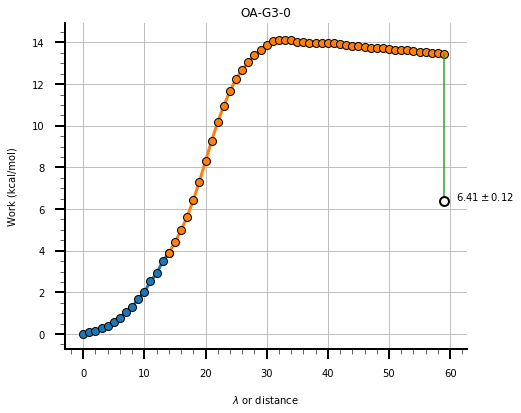

In [21]:
plot(fecalc.results['attach']['ti-block']['fe_matrix'][0], 
     fecalc.results['pull']['ti-block']['fe_matrix'][0], 
     None,
     fecalc.results["ref_state_work"],
     fecalc.results['attach']['ti-block']['sem_matrix'][0], 
     fecalc.results['pull']['ti-block']['sem_matrix'][0], 
     None,
     title='OA-G3-0')